# Evaluation of the Dense and Convolutional layer explanations

## Load RefAE and Classifier

In [1]:
import os, pathlib

file_path = os.path.dirname(os.path.realpath("__file__"))
home_dir = pathlib.Path(file_path).parent.parent
os.chdir(home_dir)

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from src.utils import SAVED_PICS_PATH, keras_dataset_image_preprocessing, DENSE_LAYER_NAME, CONV_LAYER_NAME, ALPHAS
from src.utils import SAVED_CLASSIFIER_PATH_MNIST, SAVED_CLADEC_PATH_MNIST, SAVED_REFAE_PATH_MNIST
from src.cladec import ClaDec, RefAE

_, (test_images, test_labels_c) = keras_dataset_image_preprocessing(keras.datasets.mnist)
SAVED_EVAL_PICS_PATH = SAVED_PICS_PATH.joinpath('mnist')

tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
# load classifier and split classification into correct and wrong
test_labels = np.argmax(test_labels_c, axis=1)

classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH_MNIST)
classifier_test_out = np.argmax(classifier.predict(test_images), axis=1)
label_comparison = classifier_test_out == test_labels
correct_indices = label_comparison.nonzero()[0]
label_comparison = classifier_test_out != test_labels
wrong_indices = label_comparison.nonzero()[0]

2022-07-10 11:55:12.886957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 11:55:12.916856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 11:55:12.917053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 11:55:12.917736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

313/313 [==============================] - 2s 2ms/step


## Apply ClaDec on random images from test dataset

In [4]:
# select some correctly and some misclassified images randomly

n_correct = 3
n_wrong = 5
n = n_correct + n_wrong
rand_indices_correct = np.random.choice(correct_indices, n_correct, replace=False)
rand_indices_wrong = np.random.choice(wrong_indices, n_wrong, replace=False)
rand_indices = np.concatenate((rand_indices_correct, rand_indices_wrong))
classes_correct = test_labels[rand_indices]
classes_classified = classifier_test_out[rand_indices]
eval_images = test_images[rand_indices]

In [5]:
# get ClaDec reconstructions for all models saved in `saved-models` directory
cladec_eval_data_dense = []
cladec_eval_data_conv = []
decoder_dense = ClaDec.create_128_dense_decoder()
decoder_conv = ClaDec.create_64_conv_decoder()
for alpha in ALPHAS:
    cladec_path = SAVED_CLADEC_PATH_MNIST.joinpath(f'{alpha:2}')
    cladec_dense = ClaDec.create_from_weights(cladec_path.joinpath(DENSE_LAYER_NAME).joinpath(DENSE_LAYER_NAME),
                                              classifier, DENSE_LAYER_NAME, alpha, decoder_dense)
    cladec_eval_data_dense.append(cladec_dense(eval_images))

    cladec_conv = ClaDec.create_from_weights(cladec_path.joinpath(CONV_LAYER_NAME).joinpath(CONV_LAYER_NAME),
                                             classifier, CONV_LAYER_NAME, alpha, decoder_conv)
    cladec_eval_data_conv.append(cladec_conv(eval_images))

In [6]:
# load RefAE model
refae_dense = RefAE.create_from_weights(SAVED_REFAE_PATH_MNIST.joinpath(DENSE_LAYER_NAME).joinpath(DENSE_LAYER_NAME),
                                        cladec_dense)
refae_conv = RefAE.create_from_weights(SAVED_REFAE_PATH_MNIST.joinpath(CONV_LAYER_NAME).joinpath(CONV_LAYER_NAME),
                                       cladec_conv)
# get reference reconstructions
eval_refae_dense = refae_dense(eval_images)
eval_refae_conv = refae_conv(eval_images)

## Show explanations of ClaDec for different `alpha` values.

### explaining the dense layer

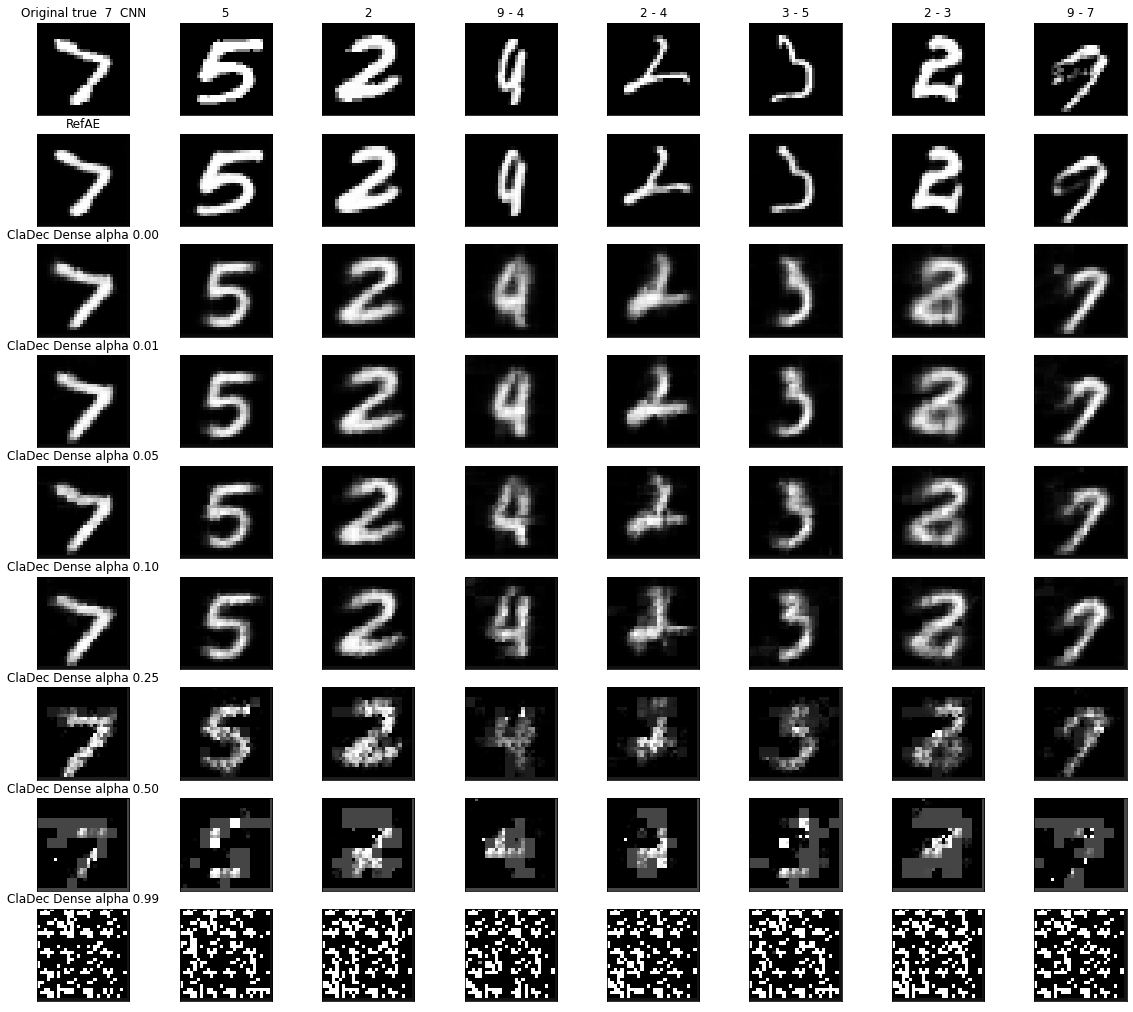

In [7]:
num_rows = 2 + len(ALPHAS)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    if classes_correct[i] == classes_classified[i]:
        title = f' {classes_correct[i]} '
    else:
        title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(ALPHAS, cladec_eval_data_dense):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Dense alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('mnist_dense.png'))
plt.show()

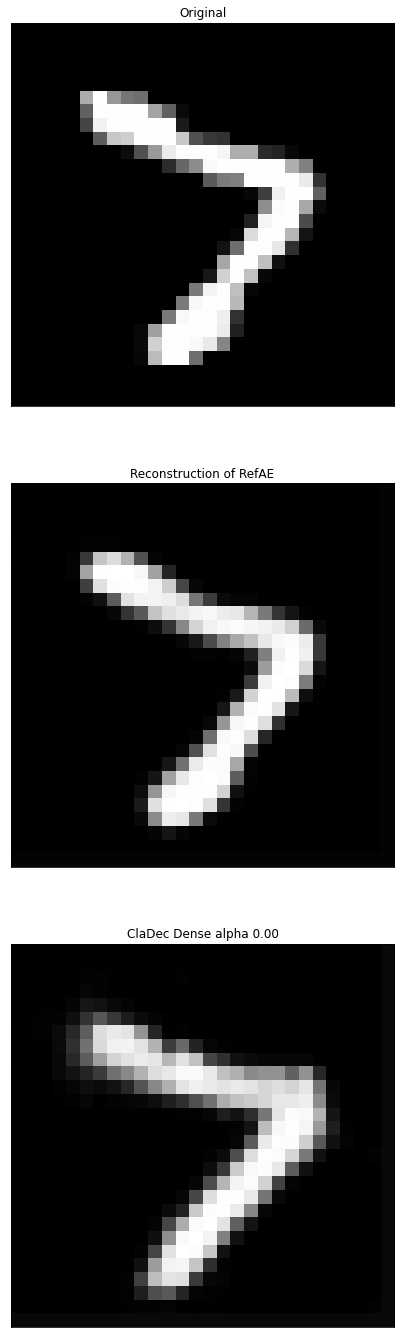

In [8]:
i = 0
plt.figure(figsize=(8, 8 * 3))

# Display Original
ax = plt.subplot(3, 1, 1)
ax.set_title("Original")
plt.imshow(eval_images[i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# Display refae
ax = plt.subplot(3, 1, 2)
ax.set_title("Reconstruction of RefAE")
plt.imshow(eval_refae_dense[i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Display cladec
alpha = 0
ax = plt.subplot(3, 1, 3)
ax.set_title(f'ClaDec Dense alpha {alpha / 100:0.2f}')
plt.imshow(cladec_eval_data_dense[0][i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('mnist_dense_single.png'))
plt.show()

### explaining the conv layer

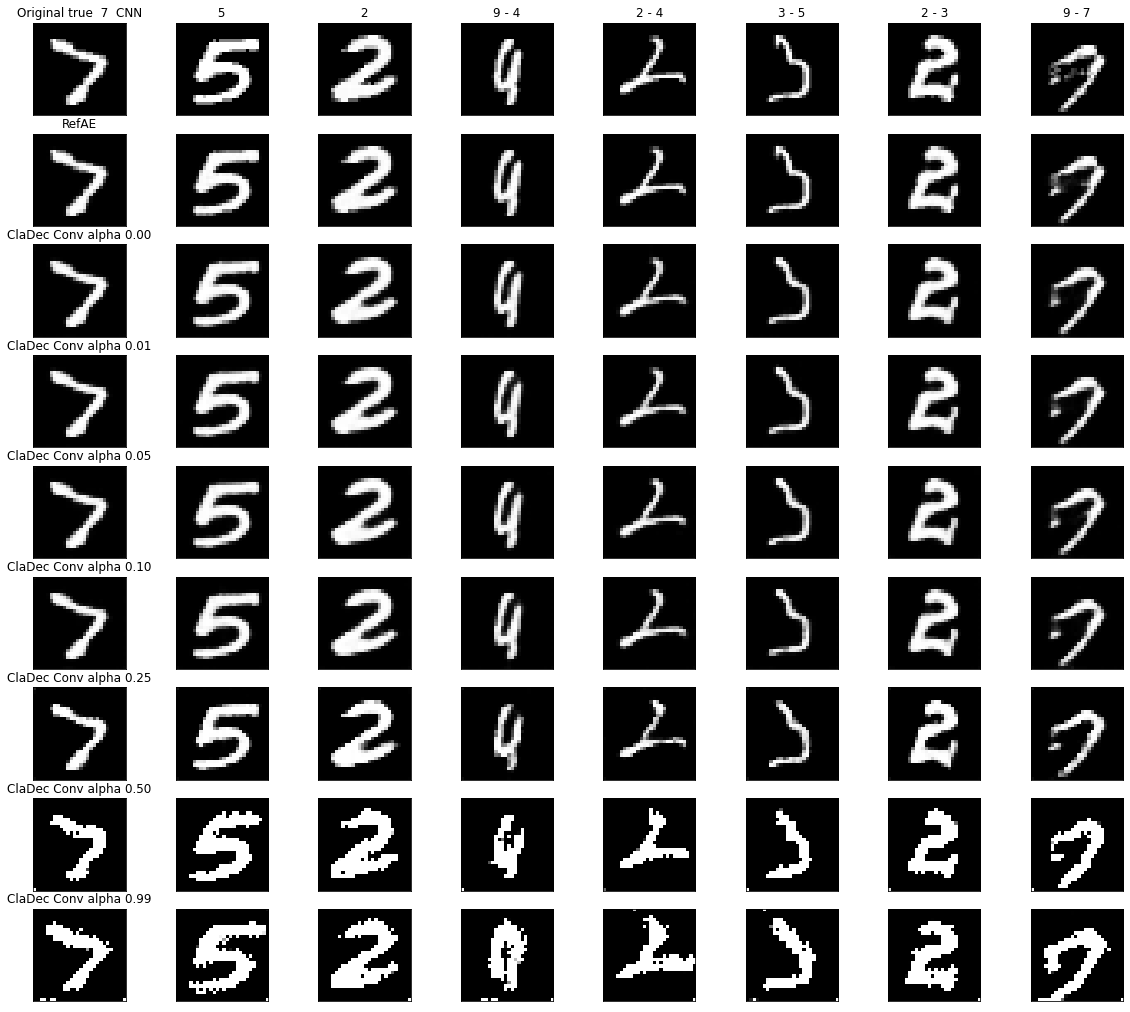

In [9]:
num_rows = 2 + len(ALPHAS)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    if classes_correct[i] == classes_classified[i]:
        title = f' {classes_correct[i]} '
    else:
        title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(ALPHAS, cladec_eval_data_conv):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Conv alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('mnist_conv.png'))
plt.show()

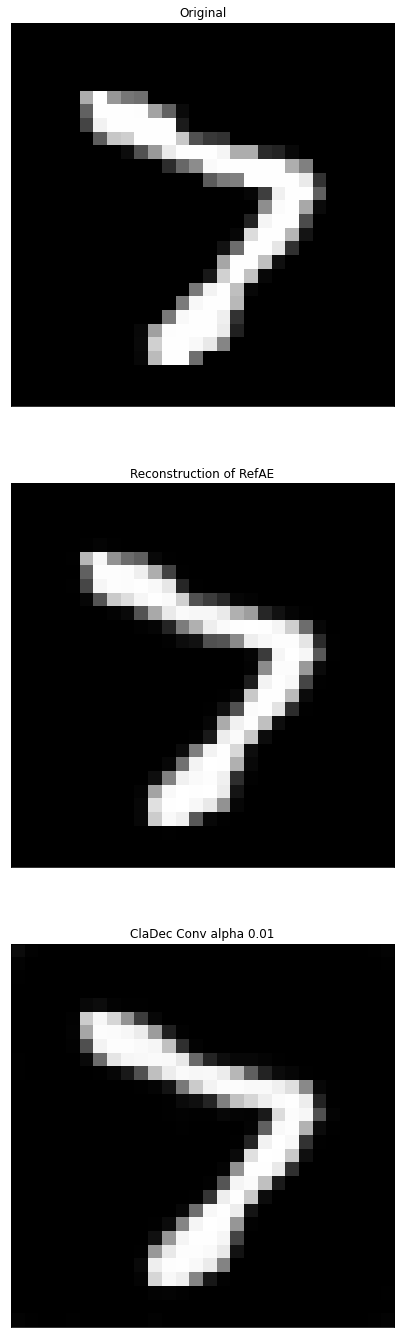

In [10]:
i = 0
plt.figure(figsize=(8, 8 * 3))

# Display Original
ax = plt.subplot(3, 1, 1)
ax.set_title("Original")
plt.imshow(eval_images[i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# Display refae
ax = plt.subplot(3, 1, 2)
ax.set_title("Reconstruction of RefAE")
plt.imshow(eval_refae_conv[i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Display cladec
alpha = 1
ax = plt.subplot(3, 1, 3)
ax.set_title(f'ClaDec Conv alpha {alpha / 100:0.2f}')
plt.imshow(cladec_eval_data_conv[1][i])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig(SAVED_EVAL_PICS_PATH.joinpath('mnist_conv_single.png'))
plt.show()